<a href="https://colab.research.google.com/github/saktiworkstation/GNNs-LLMs-Research/blob/main/GNN_DOVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.4 MB/s eta 0:00:00


In [3]:
import pandas as pd

# Load the uploaded file to examine its structure
file_path = '/content/all-pairwise-interactions.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

,PDB Code,Title,Complex Type,Biounit chain name (1),Model number (1),Chain Content (1),Biounit chain name (2),Model number (2),Chain Content (2),Mean area buried by each chain,Release Date
0,10gs,"'HUMAN GLUTATHIONE S-TRANSFERASE P1-1, COMPLEX...",HOMO,A,1,PeptideL,B,1,PeptideL,1202.7192,1998-09-16
1,121p,'STRUKTUR UND GUANOSINTRIPHOSPHAT-HYDROLYSEMEC...,HOMO,A,1,PeptideL,A-2,1,PeptideL,768.1447,1994-01-31
2,13gs,'GLUTATHIONE S-TRANSFERASE COMPLEXED WITH SULF...,HOMO,A,1,PeptideL,B,1,PeptideL,1246.4320,1999-01-13
3,15c8,"'CATALYTIC ANTIBODY 5C8, FREE FAB'",HETERO,H,1,PeptideL,L,1,PeptideL,1730.7234,1999-03-23
4,17gs,'GLUTATHIONE S-TRANSFERASE P1-1',HOMO,A,1,PeptideL,B,1,PeptideL,1258.0095,1998-12-30


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462703 entries, 0 to 462702
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PDB Code                        462703 non-null  object 
 1   Title                           462703 non-null  object 
 2   Complex Type                    462703 non-null  object 
 3   Biounit chain name (1)          462660 non-null  object 
 4   Model number (1)                462703 non-null  int64  
 5   Chain Content (1)               462703 non-null  object 
 6   Biounit chain name (2)          462646 non-null  object 
 7   Model number (2)                462703 non-null  int64  
 8   Chain Content (2)               462703 non-null  object 
 9   Mean area buried by each chain  462703 non-null  float64
 10  Release Date                    462703 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 38.8+ MB


In [5]:
data.describe()

,Model number (1),Model number (2),Mean area buried by each chain
count,462703.0,462703.0,4.627030e+05
mean,1.0,1.0,9.409008e+02
std,0.0,0.0,1.078812e+03
min,1.0,1.0,1.675434e-17
25%,1.0,1.0,2.448993e+02
50%,1.0,1.0,6.096633e+02
75%,1.0,1.0,1.301639e+03
max,1.0,1.0,7.664271e+04


In [6]:
import networkx as nx

# Extract pairs of interacting chains
edges = data[['Biounit chain name (1)', 'Biounit chain name (2)']].values

# Create a graph using NetworkX
protein_graph = nx.Graph()
protein_graph.add_edges_from(edges)

# Add node features (mean area buried) from the dataset
for _, row in data.iterrows():
    chain_1 = row['Biounit chain name (1)']
    chain_2 = row['Biounit chain name (2)']
    mean_area = row['Mean area buried by each chain']

    # Add attributes to nodes
    protein_graph.nodes[chain_1]['mean_area_buried'] = mean_area
    protein_graph.nodes[chain_2]['mean_area_buried'] = mean_area

# Display basic graph information
print(protein_graph)

Graph with 2337 nodes and 22257 edges


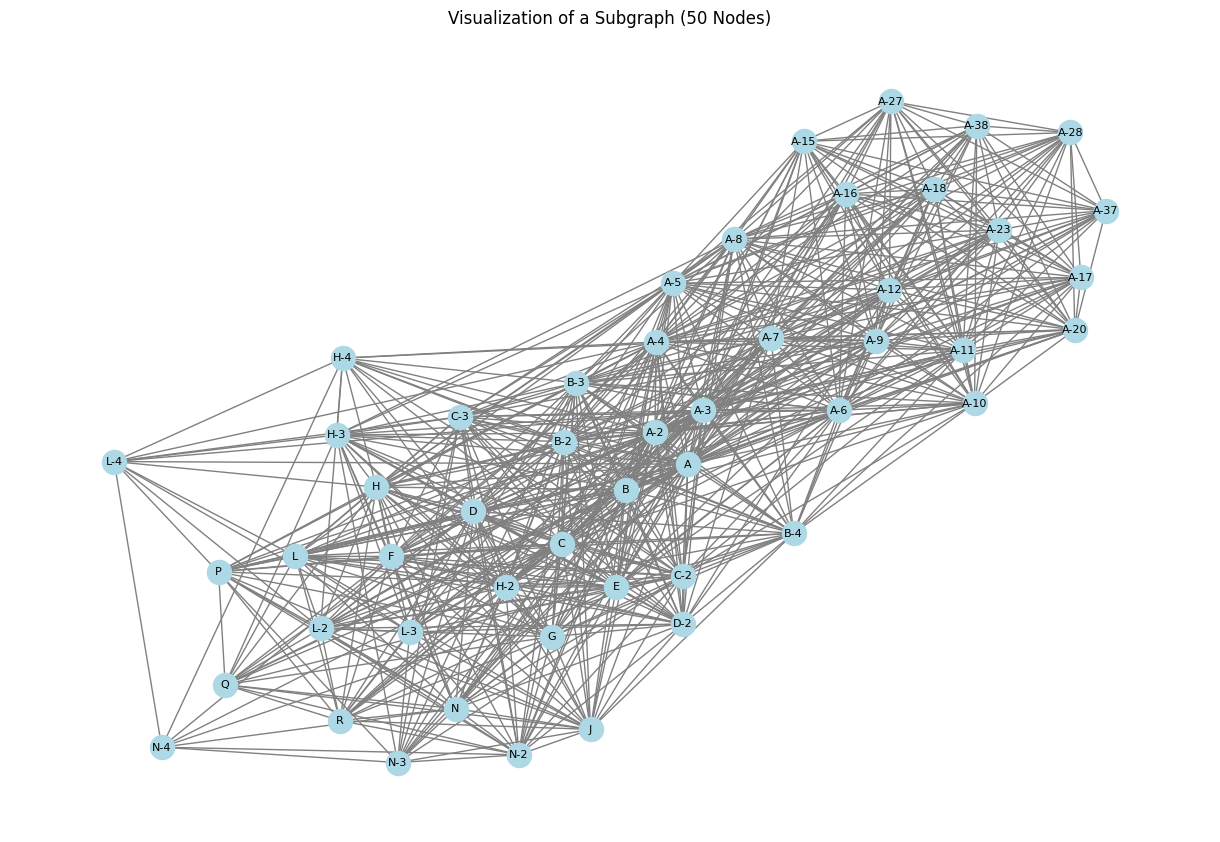

In [7]:
import matplotlib.pyplot as plt

# Visualize a subgraph (sampling a smaller portion for clarity)
subgraph = protein_graph.subgraph(list(protein_graph.nodes)[:50])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # Spring layout for better visualization
nx.draw(
    subgraph, pos,
    with_labels=True,
    node_size=300,
    node_color="lightblue",
    font_size=8,
    edge_color="gray"
)
plt.title("Visualization of a Subgraph (50 Nodes)")
plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# Scale the node features (mean_area_buried) for GNN
scaler = MinMaxScaler()
mean_areas = [
    protein_graph.nodes[node].get('mean_area_buried', 0)
    for node in protein_graph.nodes
]
scaled_features = scaler.fit_transform([[value] for value in mean_areas])

# Assign scaled features back to nodes
for idx, node in enumerate(protein_graph.nodes):
    protein_graph.nodes[node]['feature'] = scaled_features[idx][0]

# Convert NetworkX graph to PyTorch Geometric Data format
gnn_data = from_networkx(protein_graph, group_node_attrs=['feature'])

# Check the resulting graph data structure
gnn_data

Data(edge_index=[2, 44514], mean_area_buried=[2337], x=[2337, 1])

In [9]:
# Reloading and adjusting to ensure CPU compatibility in PyTorch Geometric
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# Convert the graph to PyTorch Geometric Data object, ensuring compatibility with CPU
gnn_data = from_networkx(protein_graph, group_node_attrs=['feature'])

# Ensure data object is successfully converted
gnn_data

Data(edge_index=[2, 44514], mean_area_buried=[2337], x=[2337, 1])

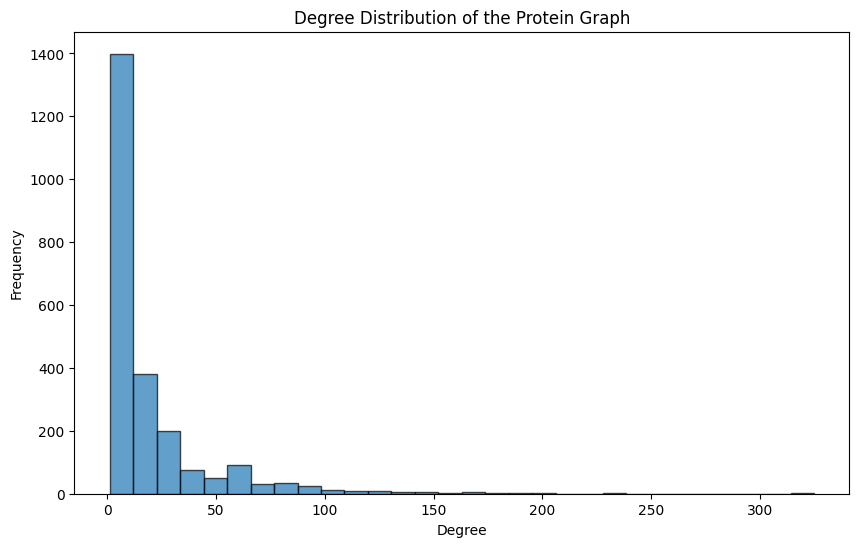

In [10]:
# Analyze the degree distribution of the graph
degrees = [degree for _, degree in protein_graph.degree()]

# Plot the degree distribution
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=30, edgecolor='black', alpha=0.7)
plt.title("Degree Distribution of the Protein Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [11]:
!pip install node2vec

Computing transition probabilities:   0%|          | 0/2337 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:14<00:00,  3.48it/s]


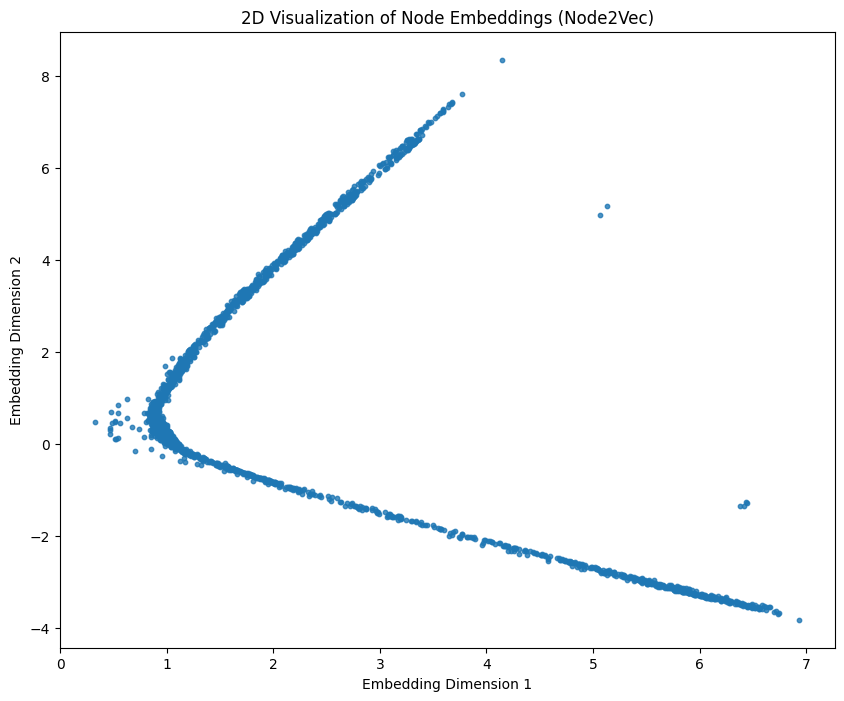

In [12]:
from node2vec import Node2Vec

# Generate node embeddings using Node2Vec
node2vec = Node2Vec(protein_graph, dimensions=2, walk_length=10, num_walks=50, workers=1, seed=42)
model = node2vec.fit(window=5, min_count=1, batch_words=4)

# Retrieve embeddings for each node
node_embeddings = {str(node): model.wv[str(node)] for node in protein_graph.nodes()}

# Prepare data for visualization
embeddings_df = pd.DataFrame(node_embeddings).T
embeddings_df.columns = ['x', 'y']
embeddings_df['node'] = embeddings_df.index

# Visualize the node embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_df['x'], embeddings_df['y'], s=10, alpha=0.8)
plt.title("2D Visualization of Node Embeddings (Node2Vec)")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.show()

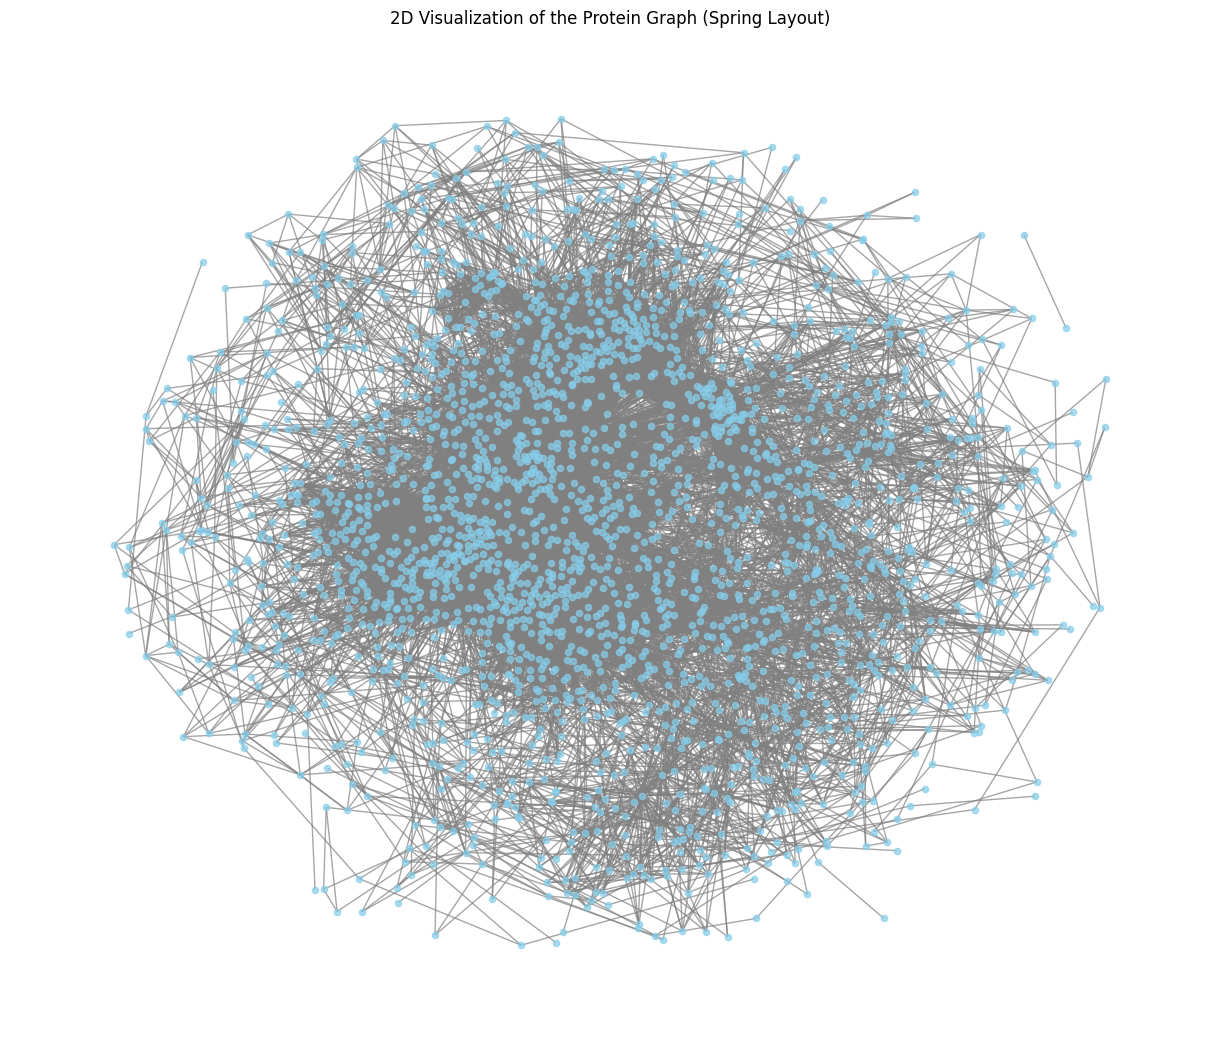

In [13]:
# Use NetworkX spring layout (force-directed layout) for 2D embedding visualization
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(protein_graph, seed=42, k=0.15)  # k controls the spacing between nodes

# Draw the graph with embeddings
nx.draw(
    protein_graph, pos,
    node_size=20, node_color="skyblue", edge_color="gray",
    with_labels=False, alpha=0.7
)

plt.title("2D Visualization of the Protein Graph (Spring Layout)")
plt.show()

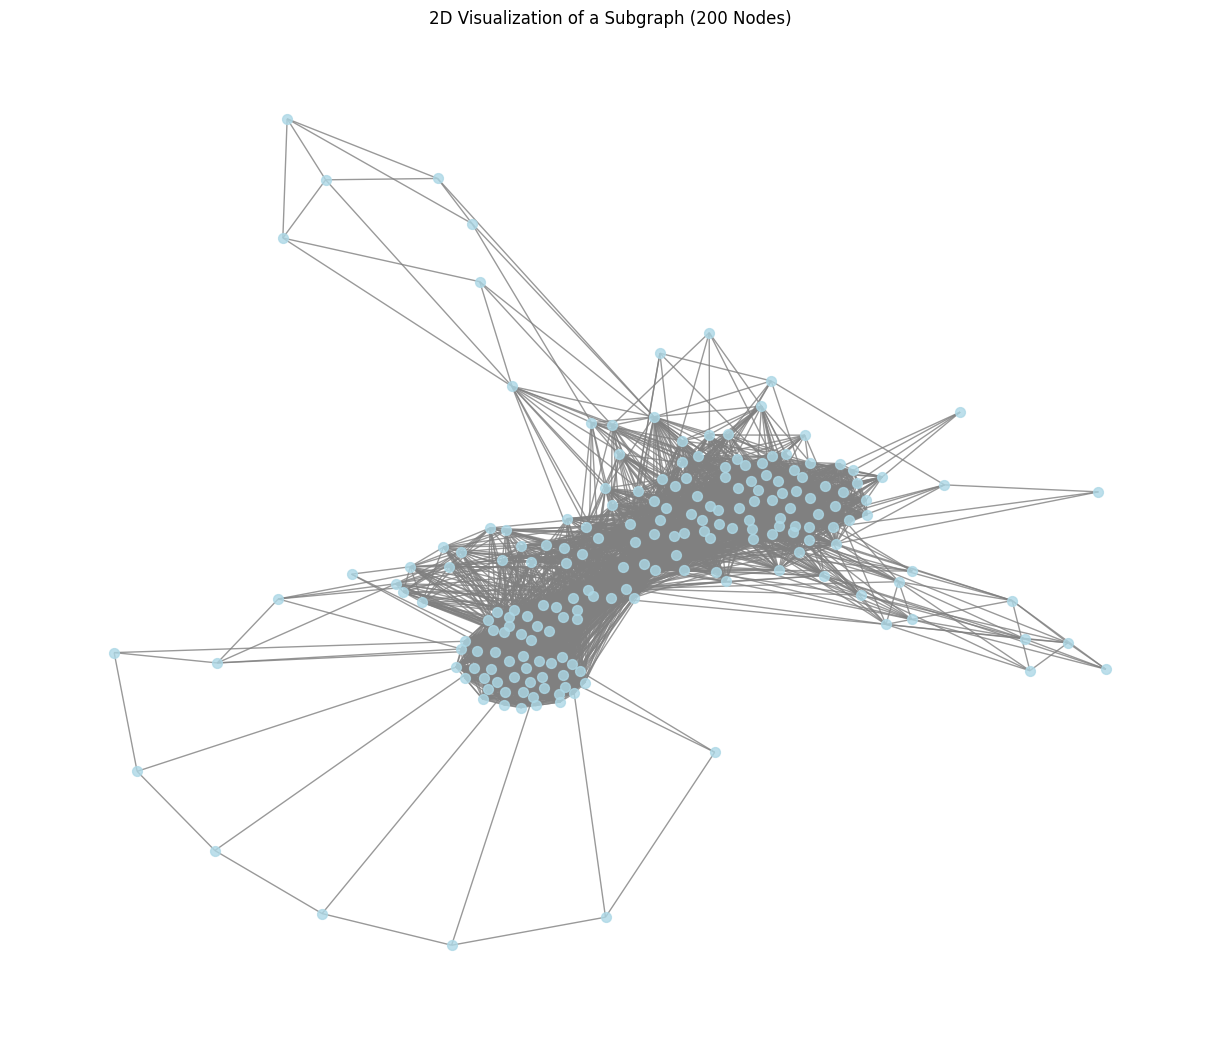

In [14]:
# Sample a smaller subgraph for visualization
subgraph_nodes = list(protein_graph.nodes)[:200]  # Select the first 200 nodes
subgraph = protein_graph.subgraph(subgraph_nodes)

# Visualize the smaller subgraph using spring layout
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(subgraph, seed=42, k=0.2)  # Adjust k for spacing

nx.draw(
    subgraph, pos,
    node_size=50, node_color="lightblue", edge_color="gray",
    with_labels=False, alpha=0.8
)

plt.title("2D Visualization of a Subgraph (200 Nodes)")
plt.show()

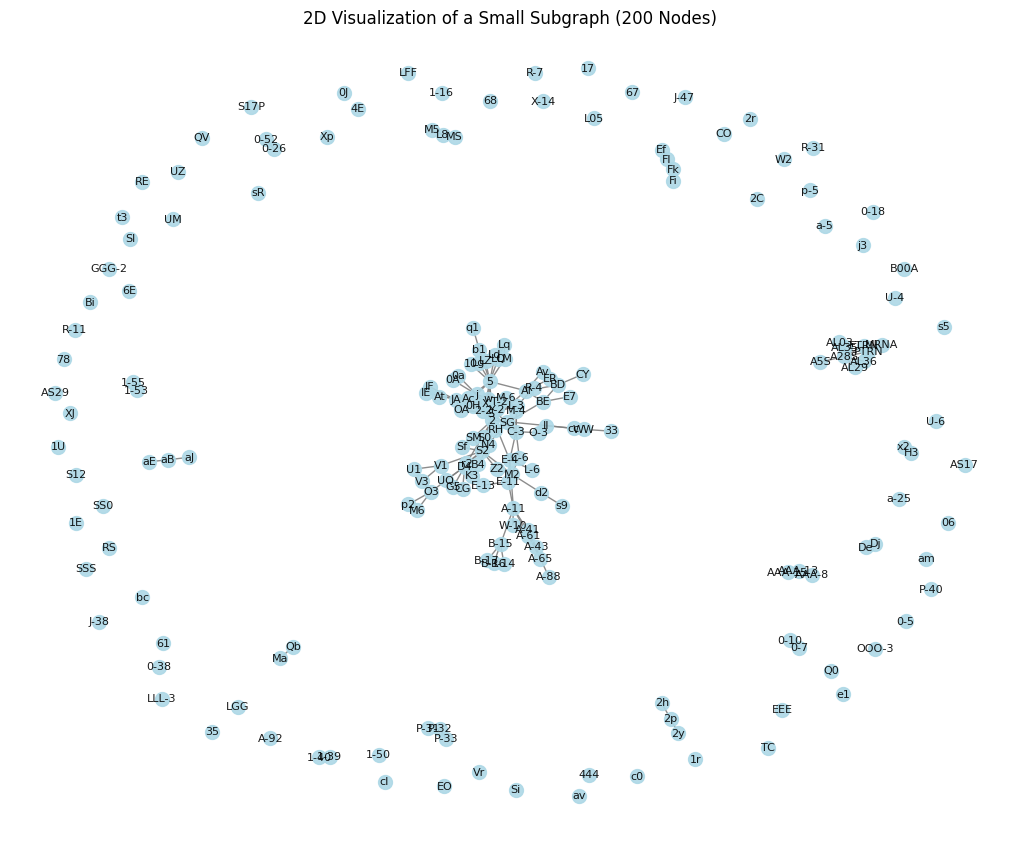

In [15]:
import random

# Sample a small subset of nodes randomly
random_nodes = random.sample(list(protein_graph.nodes), 200)
small_subgraph = protein_graph.subgraph(random_nodes)

# Visualize the very small subgraph using spring layout
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(small_subgraph, seed=42)  # Spring layout

nx.draw(
    small_subgraph, pos,
    node_size=100, node_color="lightblue", edge_color="gray",
    with_labels=True, font_size=8, alpha=0.9
)

plt.title("2D Visualization of a Small Subgraph (200 Nodes)")
plt.show()

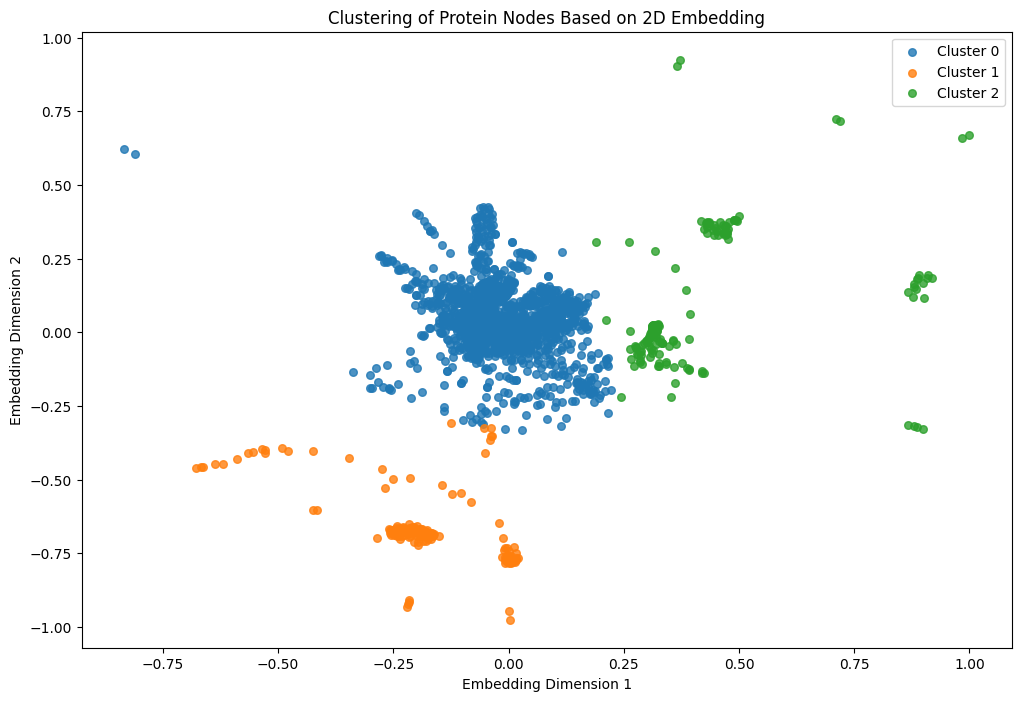

In [16]:
from sklearn.cluster import KMeans

# Extract 2D positions of nodes as embeddings using spring layout
pos = nx.spring_layout(protein_graph, seed=42)
node_positions = pd.DataFrame(pos).T
node_positions.columns = ['x', 'y']

# Apply clustering using KMeans on 2D embeddings
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(node_positions)

# Add clustering results to node positions for visualization
node_positions['cluster'] = clusters

# Visualize clusters on the 2D embedding
plt.figure(figsize=(12, 8))
for cluster_id in sorted(node_positions['cluster'].unique()):
    cluster_data = node_positions[node_positions['cluster'] == cluster_id]
    plt.scatter(cluster_data['x'], cluster_data['y'], label=f"Cluster {cluster_id}", s=30, alpha=0.8)

plt.title("Clustering of Protein Nodes Based on 2D Embedding")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.legend()
plt.show()

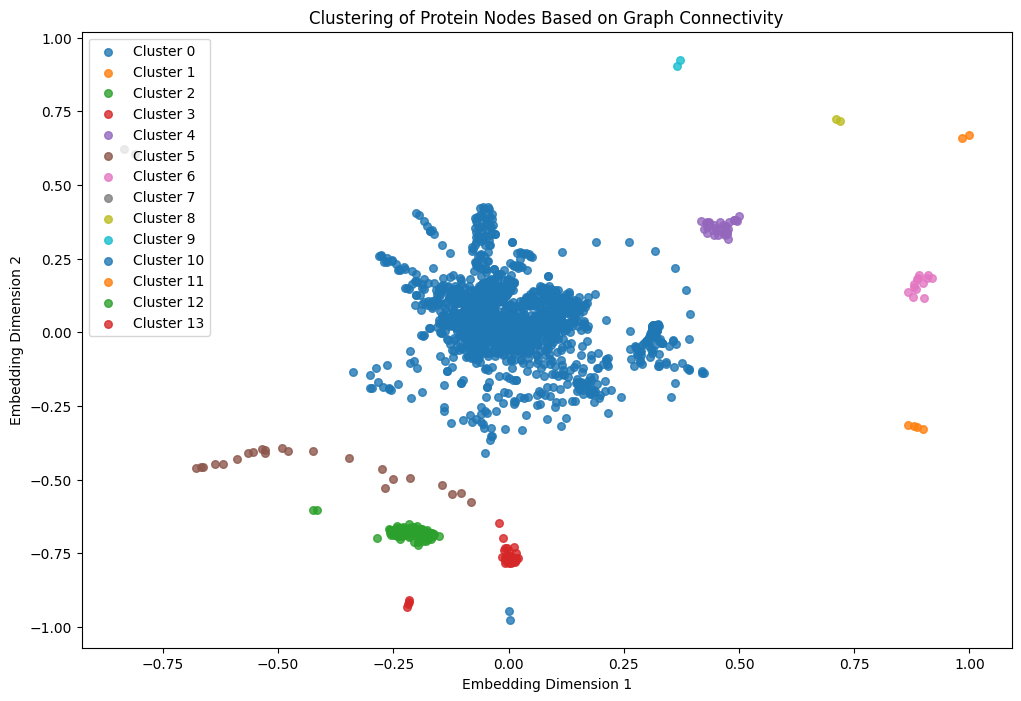

In [17]:
# Manual clustering based on graph connectivity (connected components as clusters)
from networkx.algorithms.components import connected_components

# Extract connected components (as clusters)
components = list(connected_components(protein_graph))
cluster_mapping = {}

# Assign cluster ID to each node
for cluster_id, component in enumerate(components):
    for node in component:
        cluster_mapping[node] = cluster_id

# Update node_positions DataFrame with cluster IDs
node_positions['cluster'] = node_positions.index.map(cluster_mapping)

# Visualize clusters using manually assigned cluster IDs
plt.figure(figsize=(12, 8))
for cluster_id in sorted(node_positions['cluster'].unique()):
    cluster_data = node_positions[node_positions['cluster'] == cluster_id]
    plt.scatter(cluster_data['x'], cluster_data['y'], label=f"Cluster {cluster_id}", s=30, alpha=0.8)

plt.title("Clustering of Protein Nodes Based on Graph Connectivity")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.legend()
plt.show()

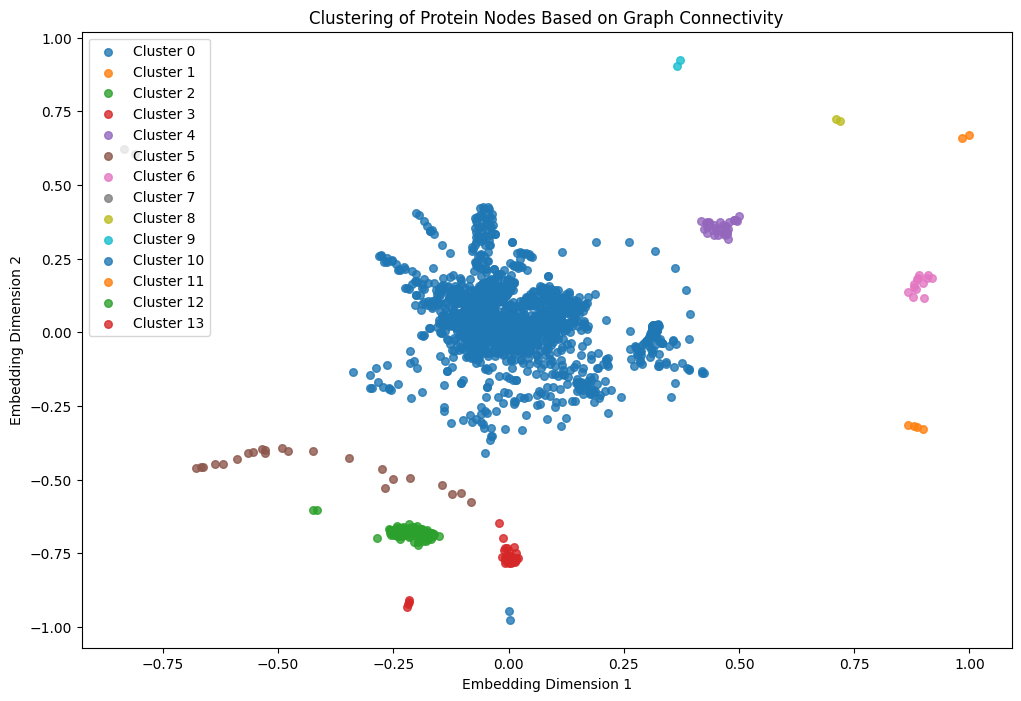

In [18]:
# Recalculate node positions using spring layout for embeddings
pos = nx.spring_layout(protein_graph, seed=42)
node_positions = pd.DataFrame(pos).T
node_positions.columns = ['x', 'y']

# Extract connected components (as clusters)
components = list(connected_components(protein_graph))
cluster_mapping = {}

# Assign cluster ID to each node
for cluster_id, component in enumerate(components):
    for node in component:
        cluster_mapping[node] = cluster_id

# Update node_positions DataFrame with cluster IDs
node_positions['cluster'] = node_positions.index.map(cluster_mapping)

# Visualize clusters using manually assigned cluster IDs
plt.figure(figsize=(12, 8))
for cluster_id in sorted(node_positions['cluster'].unique()):
    cluster_data = node_positions[node_positions['cluster'] == cluster_id]
    plt.scatter(cluster_data['x'], cluster_data['y'], label=f"Cluster {cluster_id}", s=30, alpha=0.8)

plt.title("Clustering of Protein Nodes Based on Graph Connectivity")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.legend()
plt.show()

In [ ]:
# Create a graph from the interaction pairs
edges = data[['Biounit chain name (1)', 'Biounit chain name (2)']].values
protein_graph = nx.Graph()
protein_graph.add_edges_from(edges)

# Calculate graph-based features for each node
node_features = {
    node: {
        "degree": protein_graph.degree(node),
        "clustering_coefficient": nx.clustering(protein_graph, node),
        "betweenness_centrality": nx.betweenness_centrality(protein_graph).get(node, 0)
    }
    for node in protein_graph.nodes
}

# Convert features to a DataFrame for easier manipulation
features_df = pd.DataFrame.from_dict(node_features, orient='index')

# Display the first few rows of the features DataFrame
features_df.reset_index(inplace=True)
features_df.rename(columns={"index": "node"}, inplace=True)
features_df.head()

In [19]:
# Calculate only degree and clustering coefficient to reduce computation time
node_features = {
    node: {
        "degree": protein_graph.degree(node),
        "clustering_coefficient": nx.clustering(protein_graph, node),
    }
    for node in protein_graph.nodes
}

# Convert features to a DataFrame for easier manipulation
features_df = pd.DataFrame.from_dict(node_features, orient='index')

# Reset the index and rename columns for clarity
features_df.reset_index(inplace=True)
features_df.rename(columns={"index": "node"}, inplace=True)

# Display the first few rows of the features DataFrame
features_df.head()

,node,degree,clustering_coefficient
0,A,325,0.128775
1,B,230,0.184583
2,A-2,172,0.250986
3,H,159,0.289945
4,L,134,0.335877


In [28]:
# Buat graf kembali berdasarkan pasangan interaksi
edges = data[['Biounit chain name (1)', 'Biounit chain name (2)']].values
protein_graph = nx.Graph()
protein_graph.add_edges_from(edges)

# Hitung fitur berbasis graf (degree dan clustering coefficient)
node_features = {
    node: {
        "degree": protein_graph.degree(node),
        "clustering_coefficient": nx.clustering(protein_graph, node),
    }
    for node in protein_graph.nodes
}

# Konversi ke DataFrame
features_df = pd.DataFrame.from_dict(node_features, orient='index').reset_index()
features_df.rename(columns={"index": "node"}, inplace=True)

# Siapkan label untuk klasifikasi dan regresi
# Mengasosiasikan node dengan Complex Type dan Mean Area Buried
labels_df = pd.DataFrame({
    "node": list(data['Biounit chain name (1)']) + list(data['Biounit chain name (2)']),
    "complex_type": list(data['Complex Type']) + list(data['Complex Type']),  # Duplikasi karena ada dua kolom
    "mean_area_buried": list(data['Mean area buried by each chain']) + list(data['Mean area buried by each chain'])
})

# Gabungkan fitur dengan label berdasarkan node
merged_df = features_df.merge(labels_df, on="node", how="inner")

# Tampilkan hasil penggabungan
merged_df.head()

,node,degree,clustering_coefficient,complex_type,mean_area_buried
0,A,325,0.128775,HOMO,1202.7192
1,A,325,0.128775,HOMO,768.1447
2,A,325,0.128775,HOMO,1246.4320
3,A,325,0.128775,HOMO,1258.0095
4,A,325,0.128775,HOMO,1214.1552


In [36]:
# Pastikan kembali semua impor yang dibutuhkan
import pandas as pd
import networkx as nx
import torch
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data

# Muat ulang dataset
file_path = '/content/all-pairwise-interactions.csv'
data = pd.read_csv(file_path)

# Buat kembali graf interaksi protein
edges = data[['Biounit chain name (1)', 'Biounit chain name (2)']].values
protein_graph = nx.Graph()
protein_graph.add_edges_from(edges)

# Hitung fitur berbasis graf
node_features = {}
for node in protein_graph.nodes():
    node_features[node] = {
        "degree": protein_graph.degree(node),
        "clustering_coefficient": nx.clustering(protein_graph, node)
    }

# Tambahkan fitur sebagai atribut dalam NetworkX Graph
for node, features in node_features.items():
    protein_graph.nodes[node]['degree'] = features['degree']
    protein_graph.nodes[node]['clustering_coefficient'] = features['clustering_coefficient']


# Assuming 'Complex Type' is your target variable and you want to predict it
# You might need to adjust this part based on your specific use case and how you want to define your labels
target_dict = {}
for _, row in data.iterrows():
    chain_1 = row['Biounit chain name (1)']
    chain_2 = row['Biounit chain name (2)']
    complex_type = row['Complex Type']  # Assuming 'Complex Type' is the target variable

    # Map complex types to numerical labels (e.g., 0 for 'HOMO', 1 for 'HETERO')
    if complex_type == 'HOMO':
        label = 0
    elif complex_type == 'HETERO':
        label = 1
    else:
        label = -1  # Handle unknown complex types (you might want to remove them or assign a separate label)

    target_dict[chain_1] = label
    target_dict[chain_2] = label

# Create a list of target labels for nodes
node_labels = [target_dict.get(node, -1) for node in protein_graph.nodes()]  # -1 for nodes without labels

# Create your Data object, including the labels (y)
gnn_data = from_networkx(protein_graph, group_node_attrs=['degree', 'clustering_coefficient'])
gnn_data.y = torch.tensor(node_labels, dtype=torch.long)  # Convert to PyTorch tensor


# Tampilkan informasi data yang berhasil dikonversi
gnn_data

Data(edge_index=[2, 44514], x=[2337, 2], y=[2337])

In [37]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Definisi model GNN-DOVE menggunakan Graph Convolutional Networks (GCN)
class GNN_DOVE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN_DOVE, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Inisialisasi model dengan ukuran fitur sesuai dataset
input_dim = gnn_data.x.shape[1]  # Jumlah fitur per node
hidden_dim = 16  # Dimensi lapisan tersembunyi
output_dim = 2  # Klasifikasi biner (HOMO vs HETERO)

model = GNN_DOVE(input_dim, hidden_dim, output_dim)

# Menampilkan arsitektur model
model

GNN_DOVE(
  (conv1): GCNConv(2, 16)
  (conv2): GCNConv(16, 2)
)

In [43]:
from torch_geometric.loader import DataLoader

# Persiapan DataLoader untuk PyTorch Geometric
train_loader = DataLoader([gnn_data], batch_size=1, shuffle=True)

# Optimizer dan Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

# Fungsi untuk melatih model
def train_model(model, train_loader, epochs=6000):
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)  # Forward pass
            loss = criterion(out, batch.y)  # Compute loss
            loss.backward()
            optimizer.step()
        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Melatih model
train_model(model, train_loader, epochs=6000)

Epoch 0, Loss: 0.5184603929519653
Epoch 500, Loss: 0.520453155040741
Epoch 1000, Loss: 0.5207935571670532
Epoch 1500, Loss: 0.5222631692886353
Epoch 2000, Loss: 0.5240269303321838
Epoch 2500, Loss: 0.5225543975830078
Epoch 3000, Loss: 0.5211341977119446
Epoch 3500, Loss: 0.5234752893447876
Epoch 4000, Loss: 0.5210071802139282
Epoch 4500, Loss: 0.5229968428611755
Epoch 5000, Loss: 0.5167880654335022
Epoch 5500, Loss: 0.5144776701927185


In [44]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            out = model(batch)
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')

evaluate_model(model, train_loader)

Accuracy: 0.7702
